Name: Turgunboev Dadakhon

Email: d.turgunboev@innopolis.university

---
#### [Policy Gradient](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)


###Notes on Policy Gradient
Policy Gradient is a class of reinforcement learning (RL) algorithms that optimize an agent's policy directly through gradient ascent. In RL, an agent interacts with an environment, taking actions based on its current policy to maximize the cumulative reward over time. The policy is a function that maps states to actions, and policy gradient methods aim to find the best policy to achieve the highest expected cumulative reward.

In the policy gradient framework, the policy is typically parameterized by a neural network with parameters θ. The goal is to find the optimal policy parameters θ* that maximize the expected return J(θ) from the start distribution:

θ* = argmax(θ) J(θ)

Policy gradient methods achieve this by computing the gradient of J(θ) with respect to the policy parameters θ and updating the policy parameters using gradient ascent:

θ ← θ + α ∇θ J(θ)

Here, α is the learning rate.

The gradient of the expected return J(θ) can be derived using the likelihood ratio trick, which results in the following form:

∇θ J(θ) = Eπ[∇θ log π(a|s) * Qπ(s, a)]

where π is the policy, a is the action, s is the state, and Qπ(s, a) is the action-value function, which estimates the expected return for taking action a in state s and following policy π thereafter.

In practice, the expectation in the gradient above is estimated using samples. The agent interacts with the environment, collecting a set of trajectories (state-action-reward sequences), and then updates the policy parameters using the sampled data.

The policy gradient approach has several advantages over other RL methods:

It can handle continuous action spaces, as the policy directly outputs the probabilities of taking each action.
It can learn stochastic policies, which can be beneficial in certain environments.
It often converges more reliably, as it uses gradient-based optimization.
However, policy gradient methods can suffer from high variance in the gradient estimates, which can lead to slow or unstable learning. To mitigate this issue, various techniques have been developed, such as using a baseline (e.g., the state-value function) or advanced methods like Actor-Critic, Proximal Policy Optimization (PPO), and Trust Region Policy Optimization (TRPO).

#### Actor-Critic
<img src = 'https://drive.google.com/uc?id=1CG6nQdVhdlPwncIf3VNVPPBML0Uwl6i4'/>

Actor-Critic is an algorithms that combines the benefits of both policy gradient methods and value-based methods. It consists of two main components: an actor, which represents the policy, and a critic, which represents the value function. These two components work together to optimize the agent's policy while reducing the variance in the policy gradient updates.

1. Actor: The actor is responsible for learning the policy, which maps states to actions. It represents the agent's behavior in the environment. In other words, the actor decides which actions to take in a given state. The actor is typically parameterized by a neural network and can output either discrete action probabilities (for discrete action spaces) or continuous action values (for continuous action spaces).

2. Critic: The critic is responsible for learning the value function, which estimates the expected return for a given state or state-action pair. The value function helps the agent to evaluate how good a particular state or action is. The critic is also typically parameterized by a neural network and can represent either the state-value function (V(s)) or the action-value function (Q(s, a)).

The Actor-Critic algorithm follows these main steps:

1. Initialize the actor and critic networks with random parameters.
2. The agent interacts with the environment, collecting a trajectory of states, actions, and rewards.
3. The critic network is updated using the collected data to improve its value function estimation.
4. The actor network is updated using the collected data and the critic's value function estimation to improve its policy. This is done by computing the policy gradient using the critic's estimation of the action-value function Q(s, a) or the advantage function A(s, a).
5. Steps 2-4 are repeated until a satisfactory policy is obtained or a maximum number of iterations is reached.

## Assignment 03
1.  Complete the code to train an agent on cart-pole env. (missing parts are noted with #TODO)
2.  Plot the your results
3.  Explain the results you achieved in details using your own words.
4.  Compare policy gradient with deep Q-network (No need for implementation) (for example advantages and disadvantages).


In [14]:
!pip install gymnasium torch

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym

In [16]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(Actor, self).__init__()
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        logits = self.fc2(x)
        return logits

class Critic(nn.Module):
    def __init__(self, num_inputs):
        super(Critic, self).__init__()
        self.Dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.Dropout(x)
        value = self.fc2(x)
        return value


In [17]:
env = gym.make('CartPole-v1')
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
gamma = 0.99
actor_lr = 0.0001
critic_lr = 0.0001
num_episodes = 3000

actor = Actor(num_inputs, num_actions)
critic = Critic(num_inputs)
actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
criterion = nn.MSELoss()
episode_reward_list = list()

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = actor(state_tensor)
        action_probs = torch.softmax(logits, dim=1)
        action = np.random.choice(num_actions, p=action_probs.detach().numpy()[0])

        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward

        if done:
            reward = -1

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        # TODO section:
        value = critic(state_tensor)
        next_value = critic(next_state_tensor)
        target_value = reward + gamma * next_value * (1 - int(done))
        advantage = target_value - value

        actor_loss = -torch.log(action_probs[0, action]) * advantage.item()
        critic_loss = criterion(value, target_value.detach())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    episode_reward_list.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}: Reward = {episode_reward}")


Episode 0: Reward = 10.0
Episode 10: Reward = 29.0
Episode 20: Reward = 11.0
Episode 30: Reward = 19.0
Episode 40: Reward = 24.0
Episode 50: Reward = 17.0
Episode 60: Reward = 9.0
Episode 70: Reward = 14.0
Episode 80: Reward = 25.0
Episode 90: Reward = 14.0
Episode 100: Reward = 13.0
Episode 110: Reward = 27.0
Episode 120: Reward = 17.0
Episode 130: Reward = 12.0
Episode 140: Reward = 13.0
Episode 150: Reward = 14.0
Episode 160: Reward = 15.0
Episode 170: Reward = 38.0
Episode 180: Reward = 12.0
Episode 190: Reward = 20.0
Episode 200: Reward = 18.0
Episode 210: Reward = 9.0
Episode 220: Reward = 12.0
Episode 230: Reward = 16.0
Episode 240: Reward = 11.0
Episode 250: Reward = 10.0
Episode 260: Reward = 28.0
Episode 270: Reward = 9.0
Episode 280: Reward = 10.0
Episode 290: Reward = 11.0
Episode 300: Reward = 8.0
Episode 310: Reward = 27.0
Episode 320: Reward = 20.0
Episode 330: Reward = 15.0
Episode 340: Reward = 16.0
Episode 350: Reward = 12.0
Episode 360: Reward = 11.0
Episode 370: Rew

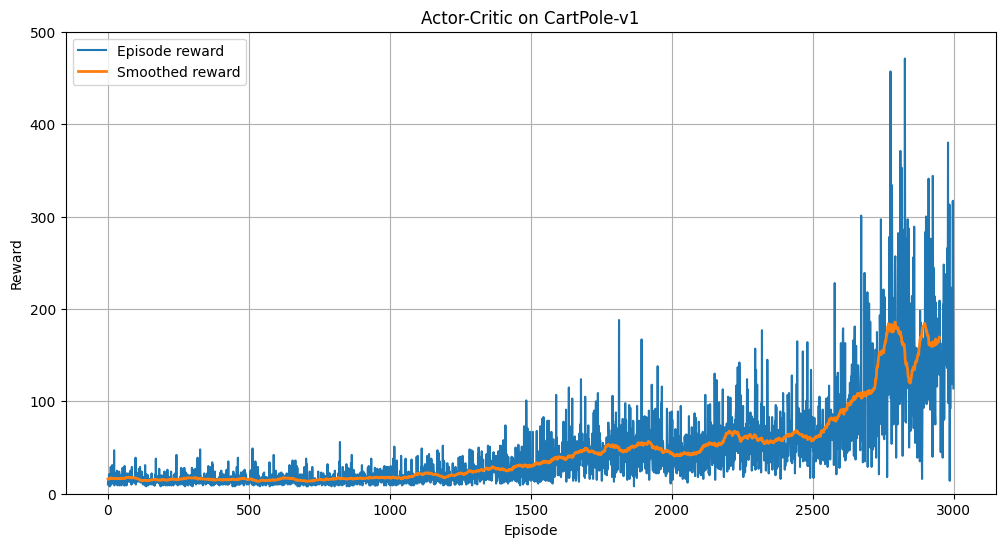

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.ylim(0, 500)
plt.plot(episode_reward_list, label="Episode reward")
plt.plot(moving_average(episode_reward_list), label="Smoothed reward", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Actor-Critic on CartPole-v1")
plt.legend()
plt.grid(True)
plt.show()


**Model Stability with Dropout**
To improve training stability, a Dropout layer with probability p=0.4 was added to the Actor network. This regularization technique helps prevent overfitting and smooths out the learning process. As a result, the model shows stable performance without large reward spikes.

The Critic network does not use Dropout, since value estimation typically benefits from more stable and deterministic learning. This balance ensures both effective policy learning and reliable value predictions.

\#TODO: explaination and comparison

Write here

| **Feature**           | **Policy Gradient (Actor-Critic)**                               | **Deep Q-Network (DQN)**                           |
|-----------------------|------------------------------------------------------------------|----------------------------------------------------|
| **Action type**       | Supports both continuous and discrete actions                    | Supports only discrete actions                     |
| **Stability**         | May suffer from high gradient variance                           | More stable, but sensitive to hyperparameters      |
| **Policy**            | Learns a stochastic policy                                       | Uses a greedy (ε-greedy) policy                    |
| **Update method**     | Directly optimizes the policy                                    | Optimizes via the Q-function                       |
| **Exploration**       | Achieved naturally through stochasticity                        | Requires ε-greedy strategy                         |
| **Advantages**        | Flexible, suitable for continuous action spaces                  | Simple and effective for discrete action problems  |
| **Disadvantages**     | Requires careful tuning, can be unstable                         | Not applicable to continuous action environments   |

### Conclusion

In conclusion, both Policy Gradient (Actor-Critic) and Deep Q-Network (DQN) are powerful reinforcement learning techniques with their own strengths. Actor-Critic methods are more flexible and suitable for complex environments with continuous action spaces, but they require careful tuning and can suffer from instability. On the other hand, DQNs are simpler to implement and work well for problems with discrete actions, though they cannot be used directly for continuous control tasks. Choosing between the two depends on the nature of the environment and the desired policy representation.
